# Estimation de graphes 

## Article : Learning graphs from data: A signal representation perspective de Dong, Xiaowen and Thanou, Dorina and Rabbat, Michael and Frossard, Pascal

## par Hugo Schnoering et Gwenn Guichaoua

### MVA - Mars 2021

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sc
import sklearn as sk
import sklearn.covariance as skc

import sys
sys.path.append("./graphical_lasso")
import graph_helpers as gh

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Modèles de signaux gaussiens

### Définition et dessin des graphes

In [ ]:
def init_graph(nom,n,k = 3,sigma=0.5,kappa=0.6):
    """ renvoie la matrice d'adjacence d'une matrice de forme mot et de n sommets """
    np.random.seed(0)
    if nom == "ligne" :
        A = np.eye(n, n, 1)+np.eye(n, n, -1)
        Vx = np.linspace(-n//2,n//2,n)
        Vy = np.zeros(n)
    elif nom == "cyclique":
        A = np.eye(n, n, 1)+np.eye(n, n, -1)
        A[n-1,0] = np.random.randn()
        A[0,n-1] = np.random.randn()

        V = np.array([np.exp(x*1j) for x in np.linspace(0,2*np.pi,n+1)])
        Vx = V.real
        Vy = V.imag
    elif nom == "grilleCarree":
        A = np.zeros((n,n))
        m =int(np.sqrt(n))
        for i in range(0,m):
            for j in range(0,m):
                if i>0:
                    A[i+j*m,(i-1)+j*m] = 1
                if j>0:
                    A[i+j*m,i+(j-1)*m] = 1
                if i<m-1:
                    A[i+j*m,(i+1)+j*m] = 1
                if j<m-1:
                    A[i+j*m,i+(j+1)*m] = 1
        a= np.linspace(0,1,m)
        Vx = np.hstack((a,)*m)
        Vy = np.vstack((a,)*m).flatten('F')

    elif nom == "kvoisins":
        Vx = np.random.rand(n,1)
        Vy = np.random.rand(n,1)
        distance =[[((Vx[i] - Vx[j])**2 + (Vy[i] - Vy[j])**2)**0.5 for j in range(0,n)] for i in range(0,n)]
        A = np.zeros((n,n))
        for i in range(0,n):
            l = distance[i]
            ll = sorted(list(enumerate(l)), key=lambda x:x[1])
            for j in ll[1:k+1]:
                A[i][j[0]] = 1
                A[j[0]][i] = 1
    elif nom == "rbf_random":
        vertices = np.random.random(size=(n, 2))
        Vx = vertices[:,0]
        Vy = vertices[:,1]
        A = np.zeros((n, n))
        for i in range(0, n):
            for j in range(i+1, n):
                dist = np.linalg.norm(vertices[i]-vertices[j])
                if dist < kappa:
                    A[j, i] = A[i, j] = np.exp(-dist**2/(2*sigma**2))
    else :
        print("Ce nom de graphe n'est pas connu, choisir ligne/cyclique/grilleCarree/kvoisins/rbf_random")
        A,Vx,Vy = [],[],[]

    return A,Vx,Vy

def dessin_graphe(P,Vx,Vy,f='black') :
    """ représente graphiquement un graphe dont P la matrice de precision est donné en argument
    Vx np.array des abscisses et Vy np.array des ordonnées des sommets """

    P = np.clip(P,-1,1)
    for i in range(P.shape[0]):
        for j in range(i) :
            col = (1,1,1)
            if P[i,j] != 0:
                if  P[i,j] >0:
                    col = tuple((1-P[i,j])*np.array((1,1,1))+P[i,j]*np.array((1,0,0)))
                else:
                    col = tuple((1+P[i,j])*np.array((1,1,1))-P[i,j]*np.array((0,0,1)))
                plt.plot([Vx[i],Vx[j]],[Vy[i],Vy[j]],c = col)

    plt.scatter(Vx,Vy,c = f,zorder = 100)

    plt.axis('off')
    plt.axis('equal')
    plt.show()

def dessin_graphe_noir(P,Vx,Vy,f='black') :
    """ représente graphiquement un graphe dont P la matrice de precision est donné en argument
    Vx np.array des abscisses et Vy np.array des ordonnées des sommets """

    P = np.clip(P,-1,1)
    for i in range(P.shape[0]):
        for j in range(i) :
            if P[i,j] < 0:
                plt.plot([Vx[i],Vx[j]],[Vy[i],Vy[j]],c = 'blue')
    plt.scatter(Vx,Vy,c = f,zorder = 100)
    plt.axis('off')
    plt.axis('equal')
    plt.show()


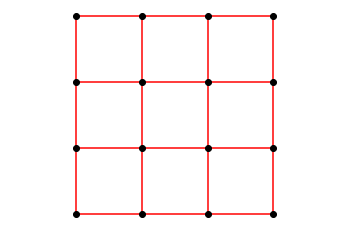

In [32]:
# on définit un graphe et sa matrice d'adjacence
num_vertices = 16
nom_graphe = "ligne"
nom_graphe = "cyclique"
nom_graphe = "kvoisin"
nom_graphe = "rbf_random"
nom_graphe = "grilleCarree" 

A,Vx,Vy = init_graph(nom_graphe,num_vertices)
dessin_graphe(A,Vx,Vy)

### Génération d'une matrice de précision, affichage du graphe et de la matrice de précision.

In [23]:
def gen_precision(nom_graphe,num_vertices,correlation_min=.9,rho=.5,sigma=0.5,kappa=0.6,k=3):
    """génération d'une matrice de précision"""
    A,Vx,Vy = gh.init_graph(nom_graphe,num_vertices,sigma=sigma,kappa=kappa,k=k)
    U = np.triu((1-correlation_min)*np.random.rand(num_vertices,num_vertices) + correlation_min)       
    Q = A*(U+U.T)     #matrice graphe pondéré
    L = np.diag(np.sum(Q, axis = 0)) - Q
    P0 = L + rho*np.eye(num_vertices) 
    return P0,Vx,Vy

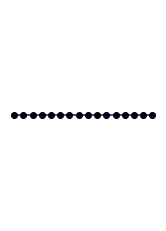

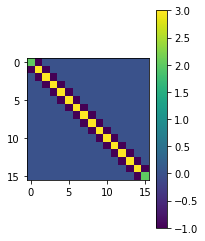

In [36]:
num_vertices = 16
nom_graphe = "ligne"
P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = 1000, kappa = .25, k=4)
plt.subplot(1,2,1)
dessin_graphe(P0,Vx,Vy)
plt.subplot(1,2,2)
plt.imshow(P0)
plt.colorbar()

### Affichage de la covariance en un sommet

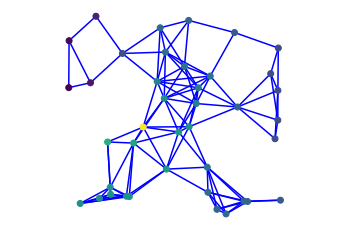

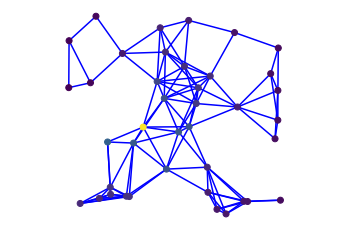

In [33]:
correlation_min = 1   #graphe non pondéré

rho_list = [1e-10,1]

nom_graphe = "kvoisins"
num_vertices = 40
k0 = num_vertices//2 # vertex central

nom_graphe = "grilleCarree"
num_vertices = 11*11
k0 = num_vertices//2 # vertex central

nom_graphe = "ligne"
num_vertices = 25
k0 = num_vertices//2 # vertex central

nom_graphe = "rbf_random"
num_vertices = 40
k0 = num_vertices//2 

for rho in rho_list:

    P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = 1000, kappa = .25, k=4)
    C0 = np.linalg.inv(P0) 
    gh.dessin_graphe(P0,Vx,Vy,C0[k0,:])

### Génération et affichage d'un signal gaussien sur le graphe (influence de $\rho$)

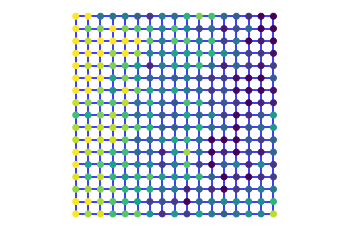

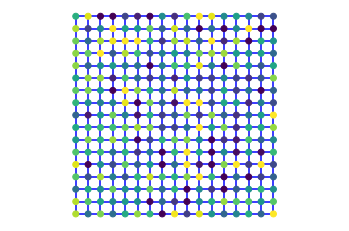

In [38]:
correlation_min = 1   #graphe non pondéré

rho_list = [1e-10,10000]



nom_graphe = "ligne"
num_vertices = 40

nom_graphe = "rbf_random"
num_vertices = 40

nom_graphe = "kvoisins"
num_vertices = 40

nom_graphe = "grilleCarree"
num_vertices = 17*17


for rho in rho_list:
    P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = 1000, kappa = .25, k=4)
    C0 = np.linalg.inv(P0)
    x = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,1)).T
    x = x-np.mean(x)
    x = x/np.std(x)
    x = np.clip(x,-1.5,1.5) 
    gh.dessin_graphe(P0,Vx,Vy,x)



# graphical lasso

On considère $n$ observations $x_{1},x_{2},\ldots ,x_{n}$. On s'interesse à l'estimation d'une matrice de précision $P_0 = C_0^{-1}$. Si on fait l'hypothèse que les $x_i$ sont tirés aléatoirement suivant un va gaussienne $Z  \sim \mathcal{N}(0,C_0)$, on espère que le $C_1= P_1^{-1}$ obtenu est une bonne estimation de la matrice de covariance $C_0$ de $Z$. 

Le graphical lasso résout
$$\operatorname {argmin} _{P \geq 0} \operatorname {tr} (C P )-\log \det(P )+\lambda \sum _{j\neq k}|P _{jk}|$$

où $C$ est la covariance des échantillons, et $\lambda$ est le paramètre de pénalisation.

Nous allons tester le graphical lasso sur les différentes formes de graphes synthétisés afin d'évaluer ses performances.

###  Influence de $\lambda$ sur la sparcité du graphe

In [ ]:
nom_graphe = "rbf_random"
num_vertices = 40
rho = 0.8
num_samples = 400

for lamda in [0.01,0.04,0.06,0.08]:
    X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
    C = X.T@X/num_samples
    C1,P1 = skc.graphical_lasso(C,lamda)
    gh.dessin_graphe_noir(P1,Vx,Vy)
    fig.tight_layout()
    fig.savefig('rbf_lambda{0}.png'.format(lamda), dpi=200) 

###  définition du score 

In [40]:
def confusion_result(P0,P1):
    n,p = P0.shape
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    tol = 1e-3
    for i in range(n):
        for j in range(i):
            if abs(P0[i,j])>tol and abs(P1[i,j])>tol:  #les 2 ont une arete
                TP +=1
            elif abs(P0[i,j])<tol and abs(P1[i,j])<tol:  #les 2 n'ont pas d'arete
                TN +=1
            elif abs(P0[i,j])<tol and abs(P1[i,j])>tol:  # arete trouvée dans P1 mais pas dasn P0
                FP +=1
            else:
                FN +=1  #arete presente dans P0 mais dasn P1
    return(TP, FP, TN, FN)

def score(nom, P0, P1):
    TP, FP, TN, FN = confusion_result(P0,P1) 
    
    if nom == 'L1':  #norme L1
        num_vertices = P0.shape[0]
        return np.linalg.norm(P0-P1,1)/num_vertices**2
    
    elif nom == 'L0':  #norme L1
        #sc_l0 = (FP+FN)/num_vertices**2
        nb_edge = np.sum( remove_diag(P0).flatten()!=0 ) # nombre d'arretes dans P0
        return 2*(FP+FN)/nb_edge
    
    elif nom == 'F1':
        return TP/(TP+0.5*(FP+FN))

### Influence de $\lambda$

In [43]:
def remove_diag(M):
    return M - np.diag(np.diag(M))

def set_lambda_max(C0):
    """ dans graphical lasso, recherche lamda_max (si lamda est trop grand, graphe sans arete)"""
    lamda = 10
    u = 0
    it = 0
    while u<1e-3 and it<100:
        C1,P1 = skc.graphical_lasso(C0,lamda)
        u = np.linalg.norm(remove_diag(P1))
        it = it+1
        lamda = lamda*.8
    assert it!=50, "probleme dans la recherche de lambda_max"
    return lamda/.8

def repport_performance(P0,num_samples,nrep=10,nlambda=30,lmax=-1,type_score='F1'):
    num_vertices = P0.shape[0]
    C0 = np.linalg.inv(P0)
    X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
    C = X.T@X/num_samples   
    if lmax<0:
        lmax = set_lambda_max(C)
    lmin = lmax/1000
    list_score = []
    lambda_list = list(np.linspace(lmin,lmax,nlambda))
    for i in range(nrep):
        X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
        C = X.T@X/num_samples
        score_l = []
        for lamda in lambda_list:
            C1,P1 = skc.graphical_lasso(C,lamda)
            score_l.append(score(type_score, P0, P1))                 
        list_score.append(score_l)
    M = np.mean(list_score, axis=0)  
    S = np.std(list_score, axis=0) 
    return lambda_list, M, S

def plot_lambda_influ(nom_graphe,correlation_min,num_vertices,sigma,num_samples,nlambda=30,type_score='F1',lmin=-1,lmax=-1,nrep=30,nom_figure=''):
        """trace score en fonction de lambda"""
        P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,sigma)
        lambda_list, M, S = repport_performance(P0,num_samples,nrep,nlambda,lmax,type_score)
        plt.plot(lambda_list,M)
        plt.fill_between(lambda_list,M-S, M+S ,alpha=0.3)        
        plt.title("Graphe {0}, correlation_min = {1}, m = {2}, sigma = {3}, n = {4}".format(nom_graphe,correlation_min,num_vertices,sigma,num_samples))
        plt.xlabel("lambda")
        plt.ylabel("score {0}".format(type_score))
        if nom_figure!='':
            plt.savefig(nom_figure) 

### différents scores : L1, L0, F1 - nous avons choisi le score F1 

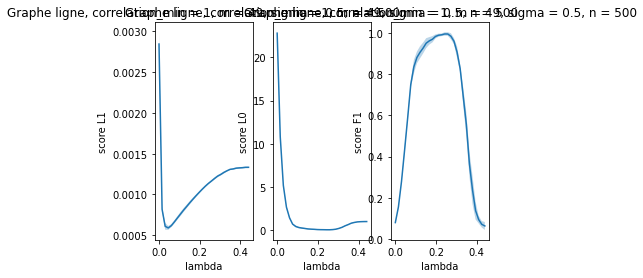

In [47]:
nom_graphe = "ligne"
num_vertices = 49
correlation_min = 1
rho = .5
num_samples = 500
plt.subplot(1,3,1)
plot_lambda_influ(nom_graphe,correlation_min,num_vertices,rho,num_samples,type_score='L1',nrep=5)
plt.subplot(1,3,2)
plot_lambda_influ(nom_graphe,correlation_min,num_vertices,rho,num_samples,type_score='L0',nrep=5)
plt.subplot(1,3,3)
plot_lambda_influ(nom_graphe,correlation_min,num_vertices,rho,num_samples,type_score='F1',nrep=5)

### influence de $\lambda$ et de $\rho$.

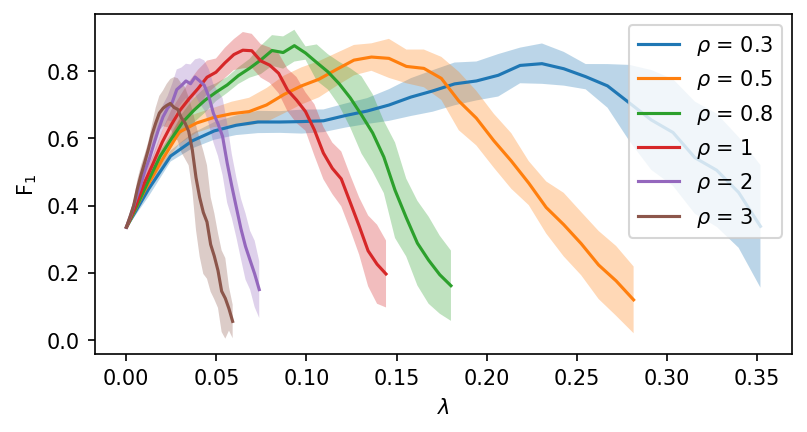

In [50]:
nom_graphe = "grilleCarree"
num_vertices = 16
num_samples = 200

fig = plt.figure(figsize=(6, 3), dpi=150) 

i = 0
for rho in [0.3,0.5,0.8,1,2,3]:
    P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = 1000, kappa = .25, k=4)
    np.random.seed(i)
    i+=1
    lambda_list, M, S = repport_performance(P0,num_samples)
    plt.plot(lambda_list,M, label = r"$\rho$ = {0}".format(rho))
    plt.fill_between(lambda_list, M-S, M+S ,alpha=0.3)
plt.legend(loc=0)
plt.xlabel("$\lambda$")
plt.ylabel("F$_1$")
plt.show() 

### influence de n et m

In [ ]:
nom_graphe = "ligne"
correlation_min = 1   #graphe non pondéré


nbr_N = 20
N_list =  np.linspace(100,500,nbr_N).astype(int)
nlambda = 20
nrep = 20
rho = 1

fig = plt.figure(figsize=(6, 3), dpi=150)
for m in [16,36,49] : 
    num_vertices = m
    P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = 1000, kappa = .25, k=4)
    score_list = np.zeros(nbr_N)
    std_list = np.zeros(nbr_N)
    for j in range(len(N_list)):
        num_samples = N_list[j]
        lambda_list, M, S = repport_performance(P0,num_samples,nrep,nlambda)
        score_list[j] = np.max(M)
        std_list[j] = S[ np.argmax(M) ]
    plt.plot(N_list,score_list, label = "$n$ = {0}".format(m))
    plt.fill_between(N_list,score_list-std_list, score_list+std_list,alpha=0.3)
plt.legend(loc=0)
plt.xlabel("nombre d'échantillons $m$")
plt.ylabel("F$_1$")
#plt.axis([100, 600, 0.85, 1])
plt.show()
fig.tight_layout()
fig.savefig('ligne_m_n_10.png', dpi=200) 

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 3.186e-04
  warnings.warn('graphical_lasso: did not converge after '


# 2. Modèles de signaux réguliers

# 3. Modèles de signaux parcimonieux

# 4. Données réelles

### Graphical Lasso

In [ ]:
f = open('financial_data.csv', "r")
lignes = f.readlines()

table = np.array([ligne.rstrip().split(",") for ligne in lignes])
X = table[1:]
X = np.asarray(X[:,1:], dtype='float64')
n_samples, n_vertices = X.shape
C = X.T@X/n_samples

lamda = 1.2e-4
C1,P1 = skc.graphical_lasso(C,lamda)
plt.subplot(1,2,1)
plt.imshow(C)
plt.subplot(1,2,2)
plt.imshow(C1)
plt.colorbar()

In [ ]:
columns_of_interest = {"Gold" : "USD (AM)", 
                       "Silver" : "USD",
                       "ETH" : "Mid", 
                       "BTC" : "Mid", 
                       "LTC" : "Mid", 
                       "ZEC" : "Mid", 
                       "Paladium" : "USD AM",
                       "Platine" : "USD AM",
                       "BNP Paribas" : "Open",
                       "Crédit Agricole" : "Open",
                       "Société Générale" : "Open",
                       "Natixis" : "Open",
                       "Hermes" : "Open",
                       "Kering" : "Open",
                       "LVMH" : "Open",
                      }

keys_tickers = list(columns_of_interest)
G = nx.Graph()

for key in columns_of_interest.keys():
    G.add_node(key)

for i in range(len(keys_tickers)):
    for j in range(i+1, len(keys_tickers)):
        if P1[i, j] < 0:
            G.add_edge(keys_tickers[i], keys_tickers[j])


pos = nx.spring_layout(G)

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, nodelist=["Gold", "Silver", "Paladium", "Platine"], node_color="b", label="Métaux précieux", alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=["BTC", "LTC", "ZEC", "ETH"], node_color="r", label="Cryptomonnaies", alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=[ "Crédit Agricole", "Société Générale", "Natixis","BNP Paribas"], node_color="g", label="Banques", alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=["Kering", "Hermes", "LVMH"], node_color="y", label="Luxe", alpha=0.3)

nx.draw_networkx_labels(G, pos, font_size=10)
plt.legend()

plt.axis("off")
plt.show()
